### Àlex Correa Orri 1564967
### Júlia Pumares Benaiges 1566252

#### Dataset explicat: https://rpubs.com/rhuebner/hrd_cb_v14
#### Descàrrega dataset: https://www.kaggle.com/rhuebner/human-resources-data-set

In [447]:
reset()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  (), please run `%reset?` for details


### MÒDULS I LLIBRERIES

In [448]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats
import os
import seaborn as sns
from scipy.stats import shapiro, spearmanr
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### DIRECTORI DE TREBALL

In [449]:
os.getcwd()
path = 'C:/Users/alexc/OneDrive/Escritorio/UNI/3er/Aprenentatge Computacional/pràctiques/PRÀCTICA 1'
os.chdir(path)
os.getcwd()
# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### LECTURA DE DADES

In [450]:
# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('HRDataset_v14_.csv')

### MODIFICACIÓ DEL DATASET

#### ELiminem atributs

In [451]:
dataset = dataset.drop(['Employee_Name','EmpID', 'MarriedID', 'DeptID', 'Zip', 'ManagerID', 'LastPerformanceReview_Date', 'MaritalStatusID', 'EmpStatusID', 'PositionID', 'Sex', 'PerformanceScore'], axis=1) 
dataset.HispanicLatino = dataset.HispanicLatino.replace({'No': 0, 'no': 0, 'Yes': 1, 'yes': 1})

#### Modifiquem atributs de dates a valors numèrics en dies

In [452]:
def date2date(list_dates):
    list_dates_def = []
    for date in list_dates:
        if (len(date.split('/')[2]) == 2):
            s = date.split('/')
            s[2] = '19'+s[2]
            date = s[0]+'/'+s[1]+'/'+s[2]
        list_dates_def.append(date)
    return list_dates_def

In [453]:
today = '1/1/2020'
#passem les dates (date of hire i date of termination) a date_time
dataset['DateofHire'] = pd.to_datetime(dataset['DateofHire'], format='%m/%d/%Y')
dataset['DateofTermination'].fillna(today, inplace = True) #posem 2020 com a data actual o de referència
dataset['DateofTermination'] = pd.to_datetime(dataset['DateofTermination'], format='%m/%d/%Y')
dataset['WorkedDays'] = (dataset['DateofTermination'] - dataset['DateofHire']).astype('timedelta64[D]')
dataset = dataset.drop(['DateofTermination', 'DateofHire'], axis=1)
#passem DOB a datetime i ho transformem a edat (per tenir una valor numèric)
dataset['DOB'] = date2date(dataset['DOB'])
dataset['DOB'] = pd.to_datetime(dataset['DOB'], format='%m/%d/%Y')
dataset['Age'] = (pd.to_datetime(today, format='%m/%d/%Y') - dataset['DOB']).astype('timedelta64[D]')
dataset = dataset.drop(['DOB'], axis=1)

#### Passem les columnes categòriques a binàries

In [454]:
columns = ['CitizenDesc', 'RaceDesc', 'TermReason', 'EmploymentStatus', 'Department', 'RecruitmentSource', 'Position', 'State', 'ManagerName', 'MaritalDesc']

for col in columns:
    if dataset[col].dtype == 'object':
        #print(col)
        dataset = pd.concat([dataset, pd.get_dummies(dataset[col], prefix=col)], axis=1)


In [455]:
dataset = dataset.drop(['CitizenDesc', 'RaceDesc', 'TermReason', 'EmploymentStatus', 'Department', 'RecruitmentSource', 'Position', 'State', 'ManagerName', 'MaritalDesc'], axis=1) 

In [456]:
dataset = dataset.rename(columns={'Department_Production       ': 'Department_Production'})

#### Treiem els 'outliers' del salari

In [457]:
list(dataset.columns)

['GenderID',
 'PerfScoreID',
 'FromDiversityJobFairID',
 'Salary',
 'Termd',
 'HispanicLatino',
 'EngagementSurvey',
 'EmpSatisfaction',
 'SpecialProjectsCount',
 'DaysLateLast30',
 'Absences',
 'WorkedDays',
 'Age',
 'CitizenDesc_Eligible NonCitizen',
 'CitizenDesc_Non-Citizen',
 'CitizenDesc_US Citizen',
 'RaceDesc_American Indian or Alaska Native',
 'RaceDesc_Asian',
 'RaceDesc_Black or African American',
 'RaceDesc_Hispanic',
 'RaceDesc_Two or more races',
 'RaceDesc_White',
 'TermReason_Another position',
 'TermReason_Fatal attraction',
 'TermReason_Learned that he is a gangster',
 'TermReason_N/A-StillEmployed',
 'TermReason_attendance',
 'TermReason_career change',
 'TermReason_gross misconduct',
 'TermReason_hours',
 'TermReason_maternity leave - did not return',
 'TermReason_medical issues',
 'TermReason_military',
 'TermReason_more money',
 'TermReason_no-call, no-show',
 'TermReason_performance',
 'TermReason_relocation out of area',
 'TermReason_retiring',
 'TermReason_retu

In [458]:
dataset = dataset[dataset['Salary'] < 125000]
#hem provat diferents valors i aquest va millor (per l'error de les regressions)

In [459]:
dataset = dataset[dataset['WorkedDays'] < 3800]

In [460]:
dataset = dataset[dataset['EngagementSurvey'] > 2.6]

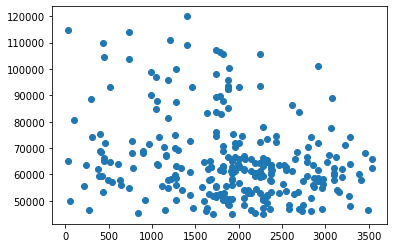

In [461]:
plt.scatter(dataset['WorkedDays'],dataset['Salary'])

### INFORMACIÓ DEL DATASET

In [462]:
data = dataset.values

x = data[:, :311]
y = data[:, 3]

print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)

Dimensionalitat de la BBDD: (275, 144)
Dimensionalitat de les entrades X (275, 144)
Dimensionalitat de l'atribut Y (275,)


In [463]:
#print("Print dataset:")
#print(dataset)

In [464]:
#print(dataset.describe())
#list(dataset.columns)

### ANALITZANT LES DADES

#### Buscant atributs amb distribució Gaussiana

C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


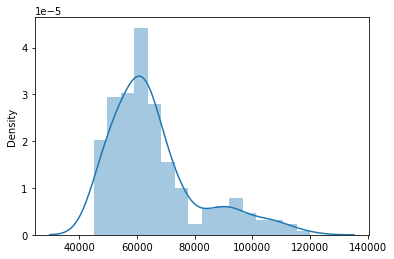

In [465]:
#provem amb el salari
ax = sns.distplot(x[:,3])


In [466]:
shapiro(x[:,3])

ShapiroResult(statistic=0.8820357322692871, pvalue=9.445971159123892e-14)

#### Visualització de les relacions entre atributs

C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


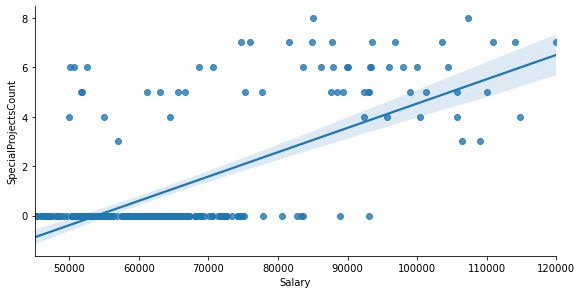

In [467]:
# Visualització de la relacó entre el salari i el recompte de projectes (SpecialProjectsCount)
sns.lmplot('Salary', 'SpecialProjectsCount', dataset, order = 1,size = 4, aspect = 2)

C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


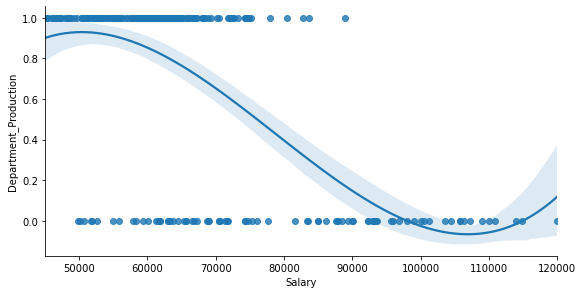

In [468]:
sns.lmplot('Salary', 'Department_Production', dataset, order = 3,size = 4, aspect = 2)

In [469]:
#Normallity tests
#HISTOGRAMA
c = 0
for col in dataset.columns:
    stat, p = shapiro(x[:,c])
    if p > 0.00000000000000005:
        print(c)
        print(p)
        print(dataset.columns[c])
        print('------------------------')
    c += 1
#v = 2
#ax = sns.distplot(x[:,v])
#no hi ha cap atribut amb distribució normal

3
9.445971159123892e-14
Salary
------------------------
6
3.6919375889787887e-10
EngagementSurvey
------------------------
7
5.846038760469929e-17
EmpSatisfaction
------------------------
10
5.761624510824959e-09
Absences
------------------------
11
0.00041846075328066945
WorkedDays
------------------------
12
1.0823467816445387e-10
Age
------------------------
23
1.0
TermReason_Fatal attraction
------------------------
44
1.0
Department_Executive Office
------------------------
63
1.0
Position_CIO
------------------------
66
1.0
Position_Data Architect
------------------------
68
1.0
Position_Director of Operations
------------------------
69
1.0
Position_Director of Sales
------------------------
71
1.0
Position_IT Director
------------------------
72
1.0
Position_IT Manager - DB
------------------------
73
1.0
Position_IT Manager - Infra
------------------------
74
1.0
Position_IT Manager - Support
------------------------
77
1.0
Position_President & CEO
------------------------
90


C:\Users\alexc\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


#### Busquem correlació entre els atributs

In [470]:
#correlació de Spearman (per a distribucions no gaussianes)
i=0
cols_corr = []
for col in dataset.columns:
    s, p = spearmanr(x[:,i], y)
    if (abs(s) > 0.25 and p < 0.05):
        print('Atribut '+ str(i) + ' ' + col)
        cols_corr.append(col)
        print(spearmanr(x[:,i], y))
        print("-----------------------------------------------------------------------------------")
    i = i + 1
#p-value < 0.05 la correlació és significant

Atribut 3 Salary
SpearmanrResult(correlation=1.0, pvalue=0.0)
-----------------------------------------------------------------------------------
Atribut 8 SpecialProjectsCount
SpearmanrResult(correlation=0.5058000198730107, pvalue=2.8705238175374173e-19)
-----------------------------------------------------------------------------------
Atribut 45 Department_IT/IS
SpearmanrResult(correlation=0.4524958911081268, pvalue=2.757256964534813e-15)
-----------------------------------------------------------------------------------
Atribut 46 Department_Production
SpearmanrResult(correlation=-0.5316119364432079, pvalue=1.8384124101486103e-21)
-----------------------------------------------------------------------------------
Atribut 48 Department_Software Engineering
SpearmanrResult(correlation=0.27969468866744146, pvalue=2.4595813592208566e-06)
-----------------------------------------------------------------------------------
Atribut 80 Position_Production Technician I
SpearmanrResult(correl

C:\Users\alexc\Anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [471]:
#restringim el dataset a aquells atributs amb el valor absolut de la correlació major a 0.10 i p-value menor a 0.05
dataset1 = dataset[cols_corr]
data = dataset1.values
x = data[:, :311]
y = data[:, 0]

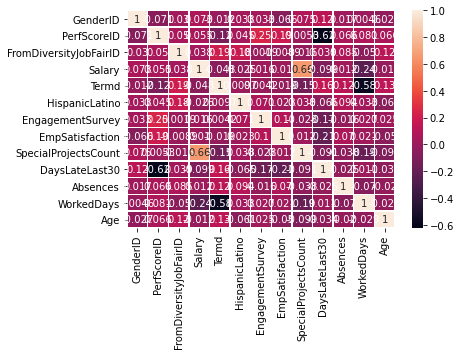

In [472]:
# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
dataset2 = dataset.iloc[:,0:13]
correlacio = dataset2.corr()

plt.figure()
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

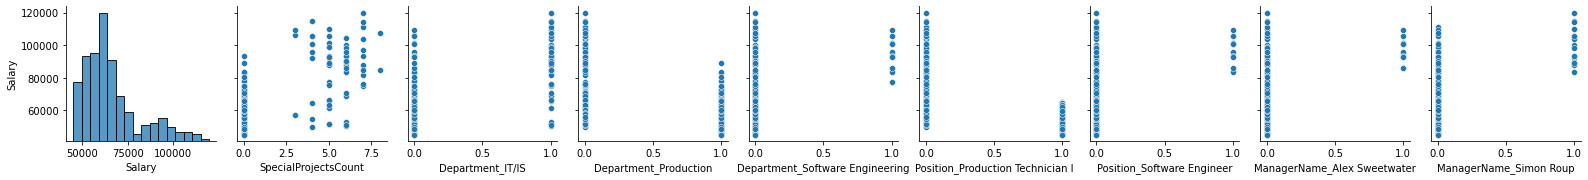

In [473]:
# Mirem la relació entre atributs utilitzant la funció pairplot
relacio = sns.pairplot(dataset1, y_vars = 'Salary')

### Histogrames

#### Quantitat de persones per rangs de salaris a continuació. Es veu com poques persones cobren molt i la majoria es troba en sous més baixos

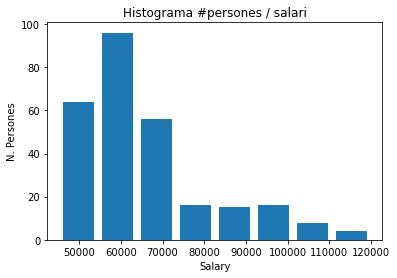

In [474]:
plt.figure()
plt.title("Histograma #persones / salari")
plt.xlabel("Salary")
plt.ylabel("N. Persones")
v = 0
hist = plt.hist(x[:,v], bins=8, range=[np.min(x[:,v]), np.max(x[:,v])], histtype="bar", rwidth=0.8)

### PRIMERES REGRESSIONS

#### FUNCIONS PER LA REGRESSIÓ

In [475]:
def mse(v1, v2):
    return ((v1 - v2)**2).mean()
def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()
    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)
    # Retornem el model entrenat
    return regr
def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean[None, :]
    x_t /= std[None, :]
    return x_t
def split_data(x_standar, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val

#### Regressió amb l'atribut at1

l'atribut: 1 SpecialProjectsCount
Mean squeared error:  136530297.8878634
R2 score:  0.43959381505179107


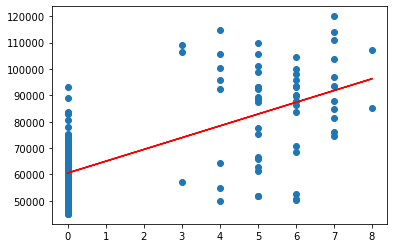

In [476]:
# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
at1 = 1
print("l'atribut: "+ str(at1) +' '+ dataset1.columns[at1])
atribut1 = x[:,at1].reshape(x.shape[0], 1) 
regr = regression(atribut1, y) 
predicted = regr.predict(atribut1)

# Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
plt.figure()
ax = plt.scatter(x[:,at1], y)
plt.plot(atribut1[:,0], predicted, 'r')
# Mostrem l'error (MSE i R2)
MSE = mse(y, predicted)
r2 = r2_score(y, predicted)

print("Mean squeared error: ", MSE)
print("R2 score: ", r2)

#### Regressió amb tots els atributs (que tenen una correlació, dataset1)

In [477]:
""" Per a assegurar-nos que el model s'ajusta be a dades noves, no vistes, 
cal evaluar-lo en un conjunt de validacio (i un altre de test en situacions reals).
Com que en aquest cas no en tenim, el generarem separant les dades en 
un 80% d'entrenament i un 20% de validació.
"""
data = dataset1.values
x = data[:, :311]
x = standarize(x)
y = x[:,0]
# Dividim dades d'entrenament
x_train, y_train, x_val, y_val = split_data(x, y)
errors = []
for i in range(x_train.shape[1]):
    x_t = x_train[:,i] # seleccionem atribut i en conjunt de train
    x_v = x_val[:,i] # seleccionem atribut i en conjunt de val.
    x_t = np.reshape(x_t,(x_t.shape[0],1))
    x_v = np.reshape(x_v,(x_v.shape[0],1))

    regr = regression(x_t, y_train)    
    error = mse(y_val, regr.predict(x_v)) # calculem error
    r2 = r2_score(y_val, regr.predict(x_v))
    errors.append(error)
    print(dataset1.columns[i])
    print("Error en atribut %d: %f" %(i, error))
    print("R2 score en atribut %d: %f" %(i, r2))
    print("------------------------------------")

#errors[0]=10
print(errors)
#print(errors.index(min(errors)))

Salary
Error en atribut 0: 0.000000
R2 score en atribut 0: 1.000000
------------------------------------
SpecialProjectsCount
Error en atribut 1: 0.453512
R2 score en atribut 1: 0.544481
------------------------------------
Department_IT/IS
Error en atribut 2: 0.615351
R2 score en atribut 2: 0.381925
------------------------------------
Department_Production
Error en atribut 3: 0.491521
R2 score en atribut 3: 0.506303
------------------------------------
Department_Software Engineering
Error en atribut 4: 0.759122
R2 score en atribut 4: 0.237518
------------------------------------
Position_Production Technician I
Error en atribut 5: 0.556995
R2 score en atribut 5: 0.440539
------------------------------------
Position_Software Engineer
Error en atribut 6: 0.767939
R2 score en atribut 6: 0.228662
------------------------------------
ManagerName_Alex Sweetwater
Error en atribut 7: 0.775014
R2 score en atribut 7: 0.221555
------------------------------------
ManagerName_Simon Roup
Error 

In [478]:
print(sorted(errors))

[5.106537590840106e-32, 0.4535116377308076, 0.491520957193328, 0.5569954275287399, 0.6153513757785197, 0.7591223441448436, 0.7679387434635492, 0.7750143232457005, 0.8113968676694949]


### EL DESCENS DEL GRADIENT

In [479]:
class Regressor(object):
    def __init__(self, w0, w1, alpha):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        self.w0 = w0
        self.w1 = w1
        self.alpha = alpha

    def predict(self, x):
        # implementar aqui la funció de prediccio: f[i] = w0 + w1 * x[i]
        hy = []
        for xx in (x):
            hy.append(self.w0 + self.w1*xx)
        return hy
    
    def __update(self, hy, y, x):
        # actualitzar aqui els pesos donada la prediccio (hy) i la y real.
        # Calculem les derivades de J respecte w0 i w1 
        m=len(y)
        d_w0 = 0
        d_w1 = 0
        for i in range(m):
            d_w0 = d_w0 + hy[i] - y[i]
            d_w1 = d_w1 + (hy[i] - y[i])*x[i]
        
        l = 0.1
        d_w0 = d_w0/m
        d_w1 = (d_w1 - l*self.w1)/m
        
        #Calculem les noves w0 i w1
        self.w1 = self.w1 - self.alpha * d_w1
        self.w0 = self.w0 - self.alpha * d_w0
    
    def train(self, max_iter, epsilon, x, y):
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon
        y_pred = self.predict(x)
        i = 0
        J = 1
        m = len(y)
        while (i < max_iter and J > epsilon):
            self.__update(y_pred, y, x)
            y_pred = self.predict(x)
            #Calculem J segons la formula
            for j in range(m):
                J = J + (y_pred[j] - y[j])**2
            l = 0.1
            J = (J + l*(self.w0**2 + self.w1**2))/(2*m)
            i += 1
            print(J)
        print("")
        print("f[i] = " + str(self.w0) + " + " + str(self.w1) + "*x[i]")
        return J, self.w0, self.w1

In [480]:
at = 1
obj_reg = Regressor(0.5, 0.5, 0.01)
obj_reg.predict(x[:,0])
max_iter = 1000
epsilon = 0.0001
J, w0, w1 = obj_reg.train(max_iter, epsilon, x[:,at], y)

0.41764691091171
0.4138900511575388
0.411238881310153
0.40864234996509313
0.40609749877958173
0.4036032958767011
0.40115873330955376
0.39876282319561085
0.3964145973112755
0.39411310670066385
0.3918574212921826
0.389646629522741
0.38747983796943364
0.3853561709885582
0.3832747703618135
0.38123479494953966
0.37923542035085817
0.37727583857057495
0.3753552576927109
0.3734729015605312
0.37162800946293995
0.36981983582711575
0.36804764991726485
0.36631073553936766
0.3646083907518015
0.36293992758171983
0.3613046717470804
0.3597019623841977
0.3581311517807238
0.356591605113938
0.35508270019424676
0.3536038272137878
0.352154388500035
0.3507337982743095
0.34934148241509333
0.3479768782260543
0.3466394342086878
0.34532860983948194
0.34404387535151715
0.34278471152041157
0.34155060945452653
0.34034107038934813
0.3391556054859569
0.3379937356335119
0.3368549912556627
0.33573891212081375
0.33464504715616716
0.33357295426546135
0.3325222001503411
0.3314923601352805
0.3304830179959875
0.32949376579

0.28080500044828827
0.2808047670682344
0.280804538405357
0.28080431436505676
0.2808040948546247
0.28080387978320354
0.2808036690617511
0.28080346260300465
0.28080326032144415
0.2808030621332592
0.28080286795631276
0.28080267771011114
0.28080249131576684
0.28080230869597084
0.28080212977495733
0.2808019544784763
0.28080178273376033
0.28080161446949753
0.28080144961580106
0.2808012881041809
0.28080112986751643
0.28080097484002825
0.2808008229572524
0.2808006741560146
0.2808005283744017
0.28080038555174053
0.2808002456285699
0.2808001085466179
0.2807999742487784
0.28079984267908614
0.28079971378269686
0.28079958750586187
0.28079946379590814
0.28079934260121575
0.2807992238711983
0.2807991075562801
0.2807989936078789
0.28079888197838276
0.2807987726211338
0.2807986654904065
0.28079856054139124
0.2807984577301745
0.2807983570137226
0.2807982583498616
0.28079816169726307
0.2807980670154247
0.28079797426465636
0.28079788340606077
0.28079779440152086
0.28079770721368136
0.28079762180593604
0.2

0.2807936355348414
0.2807936355721841
0.2807936356092504
0.28079363564604104
0.28079363568255716
0.28079363571879973
0.2807936357547689
0.28079363579046657
0.28079363582589323
0.28079363586105
0.28079363589593803
0.28079363593055817
0.2807936359649113
0.28079363599899887
0.2807936360328214
0.28079363606638136
0.2807936360996785
0.28079363613271446
0.2807936361654903
0.28079363619800785
0.2807936362302678
0.2807936362622711
0.28079363629401943
0.28079363632551413
0.2807936363567564
0.28079363638774707
0.2807936364184878
0.2807936364489799
0.2807936364792248
0.2807936365092237
0.28079363653897815
0.28079363656848877
0.2807936365977576

f[i] = 2.1585623704878533e-05 + 0.6632528253013538*x[i]


SpecialProjectsCount


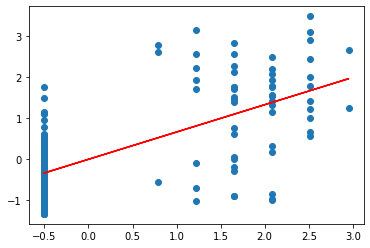

In [481]:
print(dataset1.columns[at])
plt.figure()
ax = plt.scatter(x[:,at], y)
plt.plot(x[:,at], w0+w1*x[:,at], 'r')

In [482]:
class Regressor2(object):
    def __init__(self, w0, w1, w2, alpha):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        self.w0 = w0
        self.w1 = w1
        self.w2 = w2
        self.alpha = alpha

    def predict(self, x):
        # implementar aqui la funció de prediccio: f[i] = w0 + w1 * x[i] + w2*x[i]^2
        hy = []
        for xx in (x):
            hy.append(self.w0 + self.w1*xx + self.w2*xx*xx)
        return hy
    
    def __update(self, hy, y, x):
        # actualitzar aqui els pesos donada la prediccio (hy) i la y real.
        # Calculem les derivades de J respecte w0 i w1 
        m=len(y)
        d_w0 = 0
        d_w1 = 0
        d_w2 = 0
        for i in range(m):
            d_w0 = d_w0 + hy[i] - y[i]
            d_w1 = d_w1 + (hy[i] - y[i])*x[i]
            d_w2 = d_w2 + (hy[i] - y[i])*x[i]*x[i]
        
        l = 0.1
        d_w0 = d_w0/m
        d_w1 = (d_w1 - l*self.w1)/m
        d_w2 = (d_w2 - l*self.w2)/m
        
        #Calculem les noves w0, w1 i w2
        self.w0 = self.w0 - self.alpha * d_w0
        self.w1 = self.w1 - self.alpha * d_w1
        self.w2 = self.w2 - self.alpha * d_w2
    
    def train(self, max_iter, epsilon, x, y):
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon
        y_pred = self.predict(x)
        i = 0
        J = 1
        m = len(y)
        while (i < max_iter and J > epsilon):
            self.__update(y_pred, y, x)
            y_pred = self.predict(x)
            #Calculem J segons la formula
            for j in range(m):
                J = J + (y_pred[j] - y[j])**2
            l = 0.1
            J = (J + l*(self.w0**2 + self.w1**2 + self.w2**2))/(2*m)
            i += 1
            print(J)
        #f[i] = w0 + w1 * x[i] + w2*x[i]^2
        print("")
        print("f[i] = " + str(self.w0) + " + " + str(self.w1) + "*x[i]" + " + " + str(self.w1) + "*x[i] ^2")
        return J, self.w0, self.w1

In [483]:
at = 1
obj_reg = Regressor2(0.5, 0.5, 0.5, 0.01)
obj_reg.predict(x[:,0])
max_iter = 1000
epsilon = 0.0001
J, w0, w1 = obj_reg.train(max_iter, epsilon, x[:,at], y)

0.9746854834290352
0.9190723312454822
0.8684451807699227
0.8223974450135377
0.7805018786759292
0.7423712714796793
0.7076547880357388
0.6760345455818769
0.6472225136294577
0.6209577054119909
0.597003633669596
0.5751460058885207
0.5551906364567609
0.5369615553184395
0.520299294631385
0.5050593366733216
0.49111070781913774
0.4783347048403368
0.46662374107189947
0.45588030116414974
0.4460159941991769
0.4369506959133986
0.42861177163931646
0.42093337236896056
0.41385579705663283
0.4073249149263988
0.4012916421365971
0.39571146768525267
0.39054402392182963
0.38575269746700186
0.3813042767372897
0.3771686326293939
0.37331842924331765
0.36972886181715475
0.366377419312498
0.3632436693305051
0.36030906325700623
0.3575567597328694
0.35497146472501656
0.35253928663582357
0.3502476050356811
0.34808495173668763
0.34604090304613927
0.34410598214776206
0.3422715706576724
0.3405298284917457
0.33887362126233206
0.3372964544958562
0.33579241402953974
0.3343561120058658
0.33298263793813837
0.331667514370

0.2812390025379162
0.28123712857921823
0.2812352614363298
0.2812334010086815
0.28123154719767335
0.2812296999066385
0.281227859040802
0.2812260245072445
0.28122419621486433
0.2812223740743428
0.2812205579981061
0.28121874790029333
0.2812169436967204
0.28121514530484804
0.2812133526437475
0.2812115656340688
0.2812097841980115
0.28120800825929
0.2812062377431062
0.28120447257611864
0.2812027126864141
0.281200958003479
0.28119920845817037
0.28119746398268997
0.2811957245105571
0.28119398997658246
0.28119226031684147
0.2811905354686498
0.2811888153705388
0.28118709996223173
0.2811853891846177
0.2811836829797313
0.2811819812907279
0.2811802840618625
0.2811785912384666
0.28117690276692764
0.281175218594667
0.28117353867012107
0.2811718629427199
0.28117019136286664
0.28116852388191893
0.28116686045217093
0.28116520102683357
0.28116354556001494
0.28116189400670527
0.2811602463227573
0.2811586024648695
0.28115696239056986
0.28115532605819826
0.28115369342689106
0.28115206445656604
0.28115043910

0.28059829989804447
0.2805974128377997
0.2805965268354335
0.2805956418897036
0.28059475799937034
0.2805938751631924
0.28059299337993315
0.2805921126483559
0.2805912329672252
0.2805903543353072
0.2805894767513704
0.28058860021418347
0.2805877247225177
0.2805868502751444
0.28058597687083725
0.2805851045083716
0.280584233186524
0.2805833629040717
0.2805824936597939
0.2805816254524719
0.28058075828088674
0.28057989214382273
0.2805790270400645
0.2805781629683983
0.2805772999276117
0.2805764379164942
0.2805755769338361

f[i] = 0.007377178458333496 + 0.675114116217831*x[i] + 0.675114116217831*x[i] ^2


SpecialProjectsCount


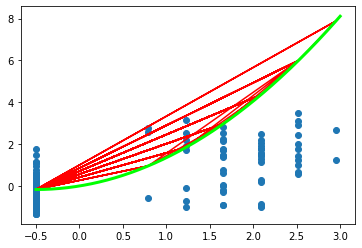

In [484]:
print(dataset1.columns[at])
plt.figure()
ax = plt.scatter(x[:,at], y)
plt.plot(x[:,at], w0 + w1*x[:,at] + w1*x[:,at]*x[:,at], color='red')
ppx = np.linspace(-0.5, 3.0, 500)
plt.plot(ppx, w0 + w1*ppx + w1*ppx*ppx, color='lime', linewidth=3)

In [485]:
class Regressor3(object):
    def __init__(self, w0, w1, w2, alpha):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        self.w0 = w0
        self.w1 = w1
        self.w2 = w2
        self.alpha = alpha

    def predict(self, x1, x2):
        # implementar aqui la funció de prediccio: f[i] = w0 + w1 * x1[i] + w2*x2[i]^2
        hy = []
        for i in range(len(x)):
            hy.append(self.w0 + self.w1*x1[i] + self.w2*x2[i])
        return hy
    
    def __update(self, hy, y, x1, x2):
        # actualitzar aqui els pesos donada la prediccio (hy) i la y real.
        # Calculem les derivades de J respecte w0 i w1 
        m=len(y)
        #d_w0 = 0
        d_w1 = 0
        d_w2 = 0
        for i in range(m):
            #d_w0 = d_w0 + hy[i] - y[i]
            d_w1 = d_w1 + (hy[i] - y[i])*x1[i]
            d_w2 = d_w2 + (hy[i] - y[i])*x2[i]
        
        l = 0.1
        #d_w0 = d_w0/m
        d_w1 = (d_w1 - l*self.w1)/m
        d_w2 = (d_w2 - l*self.w2)/m
        
        #Calculem les noves w0, w1 i w2
        #self.w0 = self.w0 - self.alpha * d_w0
        self.w1 = self.w1 - self.alpha * d_w1
        self.w2 = self.w2 - self.alpha * d_w2
    
    def train(self, max_iter, epsilon, x1, x2, y):
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon
        y_pred = self.predict(x1, x2)
        i = 0
        J = 1
        m = len(y)
        while (i < max_iter and J > epsilon):
            self.__update(y_pred, y, x1, x2)
            y_pred = self.predict(x1, x2)
            #Calculem J segons la formula
            for j in range(m):
                J = J + (y_pred[j] - y[j])**2
            l = 0.1
            J = (J + l*(self.w0**2 + self.w1**2 + self.w2**2))/(2*m)
            i += 1
            print(J)
        #f[i] = w0 + w1 * x1[i] + w2*x2[i]^2
        print("")
        print("f[i] = " + str(self.w0) + " + " + str(self.w1) + "*x1[i]" + " + " + str(self.w2) + "*x2[i] ^2")
        return J, self.w0, self.w1

In [486]:
obj_reg = Regressor3(0, 0.5, 0.5, 0.1)
at1 = 1
at2 = 2
obj_reg.predict(x[:,at1], x[:,at2])
max_iter = 1000
epsilon = 0.1
J, w0, w1 = obj_reg.train(max_iter, epsilon, x[:,at1], x[:,at2], y)
#model quadratic dona error mes gran

0.3289439530910324
0.31558497356199794
0.3074572314168637
0.30200408654684996
0.29831665156220355
0.295796570602894
0.29404896875521763
0.2928132300931484
0.29191732760704797
0.2912476898590629
0.29072931864540624
0.2903126702295463
0.2899649991802416
0.2896646466607423
0.2893972715024993
0.2891533631674784
0.2889266005394812
0.28871276882964736
0.28850904475815886
0.288313524753018
0.2881249135159617
0.28794231841944345
0.28776511374852254
0.28759285104115306
0.28742519985649373
0.28726190862985657
0.28710277878932644
0.28694764762947783
0.28679637696888577
0.28664884562864756
0.2865049444360428
0.2863645728976675
0.28622763697688364
0.2860940476022811
0.2859637196604375
0.28583657130991075
0.285712523508617
0.28559149968322334
0.285473425493311
0.28535822865898175
0.2852458388311404
0.2851361874906362
0.28502920786709113
0.28492483487127884
0.2848230050369638
0.28472365646945386
0.284626728799009
0.2845321631378595
0.2844399020399762
0.28434988946300893
0.2842620707319777
0.284176392

0.28076658405409827
0.28076658574115676
0.28076658741254407
0.2807665890683333
0.28076659070859805
0.2807665923334149
0.28076659394286135
0.28076659553701777
0.280766597115965
0.2807665986797867
0.2807666002285665
0.2807666017623904
0.2807666032813459
0.2807666047855208
0.28076660627500516
0.28076660774988893
0.28076660921026486
0.2807666106562242
0.28076661208786174
0.28076661350527155
0.28076661490854843
0.28076661629778904
0.28076661767308925
0.28076661903454675
0.2807666203822592
0.28076662171632544
0.28076662303684385
0.280766624343914
0.28076662563763505
0.28076662691810783
0.2807666281854315
0.2807666294397076
0.28076663068103647
0.28076663190951956
0.28076663312525735
0.2807666343283511
0.28076663551890313
0.2807666366970136
0.28076663786278433
0.2807666390163171
0.28076664015771247
0.28076664128707235
0.2807666424044974
0.2807666435100887
0.28076664460394735
0.28076664568617415
0.2807666467568687
0.280766647816133
0.280766648864065
0.28076664990076544
0.28076665092633435
0.280

In [487]:
print(dataset1.columns[at1])
print(dataset1.columns[at2])
p_x = x[:,at1]
p_y = x[:,at2]
p_z = w0 + w1*p_x + w1*p_y

SpecialProjectsCount
Department_IT/IS


In [488]:
pp_x = np.linspace(min(p_x), max(p_x), 311)
pp_y = np.linspace(min(p_y), max(p_y), 311)
pp_z = w0 + w1*pp_x + w1*pp_y*pp_y